In [1]:
import numpy as np
from numpy import inf as inf
from scipy.stats import binom
from heapq import heappush, heappop
import matplotlib.pyplot as plt
import timeit
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [2]:
def connectGraph(graph):
    """
    Esta función se asegura que la matriz de adyacencia que entra por parámetro defina
    un grafo conexo, lo hace agragando una conexión aleatoria que llega a un nodo 
    identificado como no conexo. 
    @param graph: Matriz de adyacencia de un grafo conexo.
    """
    n = len(graph)
    for i in range(n):
        #Suma entradas de la i esima columna sin contar la diagonal
        incoming = np.sum(np.delete(graph[:, i], i)) 
        if incoming == 0:
            pos = np.random.randint(0, n-1)
            # Nos aseguramos de no poner la nueva conexión en la diagonal
            pos = pos if pos < i else pos + 1
            graph[pos, i] = 1



def generateRandomConnectedGraph(n, connectness: float = 0.2):
    """
    Esta función genera la matriz de adyacencia de un grafo dirigido, con pesos entre 1 y 50. 
    simplemente conexo y con N nodos.
    @param n: Número de nodos del grafo
    @param connectness: indica, en promedio, el porcentaje de vertices que llegarán y saldrán de un nodo. 
    El rango es entre 0 y 1.
    return: Matriz de adyacencia del grafo y la matriz de pesos
    """
    # Una grafo simplemente conexo tendrá, por cada columna, al menos un valor distinto de
    # cero en las entradas que no son la perteneciente a la diagonal. i.e, para que sea
    # conexo, por cada nodo, siempre debe haber un vertice que llega a dicho nodo

    # Inicialización de los vertices del grafo. 
    adyacencia = np.double(binom.rvs(1, connectness, size=n*n).reshape((n, n)))
    # Nos aseguramos que sea conexo
    connectGraph(adyacencia)
    # Generamos los pesos
    pesos = np.multiply(adyacencia, np.random.randint(1, 51, (n, n)))
    # Si no hay conexión a un nodo el peso es infinito
    pesos[pesos == 0] = inf 

    return adyacencia, pesos


In [3]:
grafo, pesos = generateRandomConnectedGraph(10, connectness = 0.5)
print(pesos)

[[50. inf inf 18. 30. 24. 40. inf 25. inf]
 [inf inf 50. inf inf inf inf inf 49. inf]
 [inf inf inf inf 50. inf inf 50. 32. 15.]
 [12. inf inf inf inf 29. inf  1.  2. inf]
 [48. 49. 27. inf inf inf inf inf 15. inf]
 [inf 24. inf 39. 24. 13. 13. 24.  7. inf]
 [inf inf 17. inf 38. inf inf 11. inf 33.]
 [inf 42. 45. 17. 13. inf inf inf inf 18.]
 [29. inf 48.  9. 47. 34. 50. 45. 34.  3.]
 [inf inf  1. inf 32. inf inf 35. 19. 23.]]


In [4]:
def execTime(func):
    """
    Definici;on de un decorador que se usa para retornar el tiempo 
    de ejecución de una función. 
    @param func. La función a la que se le medirá el tiempo de ejecución
    @return time, result. 
    time: Tiempo en segundos de la ejecución de la función.
    result: Resultado de la función. 
    """
    def wrapper(*args, **kwargs):
        init_time = timeit.default_timer()
        result = func(*args, **kwargs)
        stop_time = timeit.default_timer()
        total = stop_time - init_time
        return total, result
    return wrapper

In [5]:
@execTime
def dijkstra(pesos, init):
    """ 
    Implementación eficiente de Dijkstra usando priority queue con la librería
    de Python heapq (no hay que descargarla, hace parte del core de Python)
    @param pesos: Matriz de pesos de grafo dirigido. Solo positivos.
    @param init: Nodo de inicio del algoritmo. Debe estar entre 0 y len(pesos) - 1.
    """

    # Número de nodos
    n = len(pesos)

    # Inicialización de arreglos auxiliares y el vector respuesta (path)
    dist = np.ones(n) * inf
    visited = np.array([False for i in range(n)])
    path = np.ones(n) * -1

    dist[init] = 0
    visited[init] = True

    heap = []
    # Priority queue. Se ordena el heap basado en la primera entrada de la tupla 
    # (distancia, posicion) que se le pasa. Sacar el mínimo es O(1)
    heappush(heap, (dist[init], init))

    while len(heap) > 0:

        (minimo, nodoMin) = heappop(heap)
        nodoMin = int(nodoMin)
        visited[nodoMin] = True

        # Se recorren los nodos con pesos menores a infinito (los vecinos)
        for v in (v for v, peso in enumerate(pesos[nodoMin, :]) if peso < inf):
            if not visited[v]:
                # print('min: ',  nodoMin, 'v:', v, '-', dist[nodoMin], '-', pesos[nodoMin, v])

                # Si el nodo no ha sido visitado y la distancia desde el actual es menor
                # Entonces se actualiza su distancia
                if dist[v] > dist[nodoMin] + pesos[nodoMin, v]:

                    dist[v] = dist[nodoMin] + pesos[nodoMin, v]
                    path[v] = nodoMin
                    heappush(heap, (dist[v], v))

    return path


In [6]:
time, path = dijkstra(pesos, 3)
print('La función demoró:', time*1000, 'ms corriendo')
print(path)

La función demoró: 0.14660000000010776 ms corriendo
[ 3.  7.  9. -1.  7.  3.  5.  3.  3.  8.]


In [7]:
@execTime
def opti(pesos, init, fin):
    pesos = generateRandomConnectedGraph(20, connectness=0.2)[1]
    # print("pesos", pesos)
    Model = ConcreteModel()

    # SETS & PARAMETERS********************************************************************
    numNodes = 5

    N = RangeSet(1, numNodes)

    cost = dict()
    for u in range(len(pesos)):
        for v in range(len(pesos[u])):
            if pesos[u][v] == inf:
                cost[u, v] = 999
            else:
                cost[u, v] = pesos[u][v]

    """
    cost={(1,1):999, (1,2):5,   (1,3):2,   (1,4):999, (1,5):999,\
          (2,1):999, (2,2):999, (2,3):999, (2,4):999, (2,5):8,\
          (3,1):999, (3,2):999, (3,3):999, (3,4):3,   (3,5):999,\
          (4,1):999, (4,2):999, (4,3):999, (4,4):999, (4,5):2,\
          (5,1):999, (5,2):999, (5,3):999, (5,4):999, (5,5):999}
    """

    # print("cost", cost)

    # VARIABLES****************************************************************************
    Model.x = Var(N, N, domain=Binary)

    # OBJECTIVE FUNCTION*******************************************************************
    Model.obj = Objective(expr=sum(Model.x[i, j] * cost[i, j] for i in N for j in N))

    # CONSTRAINTS**************************************************************************
    def source_rule(Model, i):
        if i == init:
            return sum(Model.x[i, j] for j in N) == 1
        else:
            return Constraint.Skip

    Model.source = Constraint(N, rule=source_rule)

    def destination_rule(Model, j):
        if j == fin:
            return sum(Model.x[i, j] for i in N) == 1
        else:
            return Constraint.Skip

    Model.destination = Constraint(N, rule=destination_rule)

    def intermediate_rule(Model, i):
        if i != init and i != fin:
            return sum(Model.x[i, j] for j in N) - sum(Model.x[j, i] for j in N) == 0
        else:
            return Constraint.Skip

    Model.intermediate = Constraint(N, rule=intermediate_rule)

    # APPLYING THE SOLVER******************************************************************
    SolverFactory('glpk').solve(Model)

    # Model.display()
    
    return 0

In [8]:
def graphExecutionTimes(samples=50, maxNodes=200, connectness = 0.5):
    """
    Función principal que se encarga de graficar el tiempo de ejecución de Dijkstra y 
    optimización dado el crecimiento de los nodos.

    @param samples: Número de muestras de grafos que se generarán por cada incremento en el 
    número de nodos. Los resultados graficados será el promedio de estas muestras
    @param masNodes: Número máximo de nodos a evaluar. Se empieza con grafos de 5 nodos y aumenta
    progresivamente el número de nodos hasta este valor.
    @param connectness: Qué tan conectados van a estar los grafos creados. Toma un valor entre 0 y 1. 
    Que este en 0 no significa que el grafo no sea conexo, siempre nos aseguramos que cualquier grafo
    generado sea conexo. A grandes rasgos este número indica, para un nodo, el porcentaje del total de
    nodos conectados a él. 
    """

    dijkstraTimes = []
    optiTimes = []

    for n in range(5, maxNodes):

        sampleTimeDij = []
        sampleTimeOpti = []
        # print(n)

        for sample in range(samples):
            # Genera un grafo conexo de n nodos
            grafo, pesos = generateRandomConnectedGraph(n, connectness = connectness)
            startNode = np.random.randint(0, n)
            array = list((v for v in range(n) if v != startNode))
            # print(startNode, array)
            endNode = np.random.choice(array)

            # Primero con dijkstra
            nthTime, path = dijkstra(pesos, startNode)
            sampleTimeDij.append(nthTime)

            # Ahora con optimización
            nthTime, zero = opti(pesos, startNode, endNode)
            sampleTimeOpti.append(nthTime)
        
        avgTime = sum(sampleTimeDij) / len(sampleTimeDij)
        dijkstraTimes.append(avgTime)
        
        avgTimeOpti = sum(sampleTimeOpti) / len(sampleTimeOpti)
        optiTimes.append(avgTimeOpti)
        
        print(avgTime, avgTimeOpti)
    

    # Plot results
    E = lambda V: V*(V-1)*connectness #Número aproximado de vertices según el algoritmo de generación
    dijkComplFunc = lambda V: V + E(V)*np.log(V)

    # Factor de Reajuste del cálculo de complejidad (Empírico)
    C = min(np.array(dijkstraTimes[:5]))/80
    dijkCompl = np.array([dijkComplFunc(V) for V in range(5, maxNodes)]) * C

    plt.plot(list(range(5, maxNodes)), dijkstraTimes*1000, color='b', label='Tiempos usando Dijkstra')
    plt.plot(list(range(5, maxNodes)), optiTimes*1000, color='r', label='Tiempos usando Optimización')
    plt.plot(list(range(5, maxNodes)), 
            dijkCompl*1000, color='y', 
            label='Complejidad Teórica de Dijsktra O(V + E LogV)')
    plt.legend()
    plt.title('Comparación tiempos Dijsktra vs Optimización')
    plt.xlabel('Número de Nodos')
    plt.ylabel('Tiempo de ejecución (ms)')
    plt.grid()
    plt.show()





4.473499999998465e-05 0.04103453500000002
4.355000000004772e-05 0.035039394999999994
6.730499999991757e-05 0.034880225000000056
7.565500000012992e-05 0.03501216000000014
7.479500000000528e-05 0.034501880000000006
0.00010014499999999593 0.035195200000000024
0.00011313999999988944 0.03416494500000002
0.0001212000000000657 0.030971460000000083
0.0001366700000001053 0.03128438999999994
0.00015769499999978008 0.039987864999999845
0.00020481999999990563 0.034296349999999885
0.00020747500000011242 0.03222847499999988
0.00021368999999999972 0.031658965000000094
0.0002369449999999773 0.03178718999999974
0.0003324449999998258 0.04044370999999991
0.00029166499999986326 0.0345891449999999
0.00037837500000001965 0.034817115000000065
0.0003821599999998426 0.03554253000000003
0.00046367500000013 0.03483313999999993
0.0004058200000001122 0.032106835
0.000459754999999884 0.031797344999999755
0.0004877700000001539 0.038272764999999785
0.0007029199999996294 0.035242470000000206
0.0006546900000001799 0.03

ValueError: x and y must have same first dimension, but have shapes (195,) and (195000,)

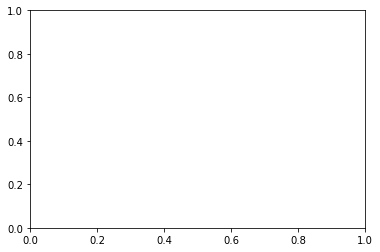

In [9]:
graphExecutionTimes(samples=20, maxNodes=200, connectness = 0.3)